In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\trung\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\trung\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\trung\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
dataset = pd.read_csv("train_set.csv")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4619 entries, 0 to 4618
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        4619 non-null   int64 
 1   venue     4619 non-null   object
 2   category  4619 non-null   object
dtypes: int64(1), object(2)
memory usage: 108.4+ KB


In [3]:
dataset["category"].value_counts()

category
ISI Q1/Q2                1101
International Conf       1100
Domestic Journal          660
Scopus Conf               642
ISI Q3/Q4                 268
Scopus Journal            261
International Journal     219
Domestic Conf             205
Technical report           74
Patent                     48
Book chapter               34
Book                        7
Name: count, dtype: int64

In [4]:
target_category = dataset['category'].unique()
target_category

array(['ISI Q1/Q2', 'ISI Q3/Q4', 'Scopus Journal', 'International Conf',
       'Domestic Journal', 'Domestic Conf', 'Book chapter', 'Patent',
       'Scopus Conf', 'Book', 'International Journal',
       'Technical report '], dtype=object)

In [5]:
dataset["categoryId"] = dataset["category"].factorize()[0]
dataset.head()

,id,venue,category,categoryId
0,27,BMC plant biology,ISI Q1/Q2,0
1,29,Rice,ISI Q1/Q2,0
2,35,Sensors,ISI Q1/Q2,0
3,41,Sensors,ISI Q1/Q2,0
4,43,IEEE Transactions on Knowledge and Data Engine...,ISI Q1/Q2,0


In [6]:
category = dataset[['category', 'categoryId']].drop_duplicates().sort_values('categoryId')
category

,category,categoryId
0,ISI Q1/Q2,0
1101,ISI Q3/Q4,1
1369,Scopus Journal,2
1630,International Conf,3
2730,Domestic Journal,4
3390,Domestic Conf,5
3595,Book chapter,6
3629,Patent,7
3677,Scopus Conf,8
4319,Book,9


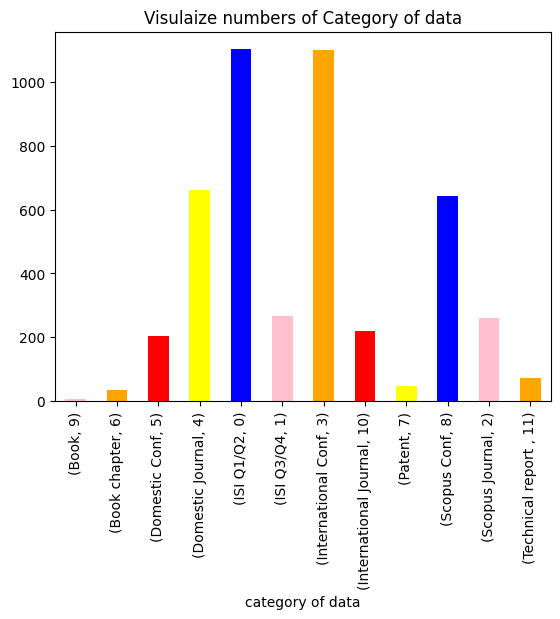

In [7]:
dataset.groupby('category').categoryId.value_counts().plot(kind = "bar", color = ["pink", "orange", "red", "yellow", "blue"])
plt.xlabel("category of data")
plt.title("Visulaize numbers of Category of data")
plt.show()

In [8]:
def remove_specialchar(text):
   text = re.sub('[^a-zA-Z0-9 ]', '', text)
   return text.lower()
dataset['venue'] = dataset['venue'].apply(remove_specialchar)
dataset['venue']

0                                       bmc plant biology
1                                                    rice
2                                                 sensors
3                                                 sensors
4       ieee transactions on knowledge and data engine...
                              ...                        
4614    international scientific conference on current...
4615                        arxiv preprint arxiv231111732
4616                                              biorxiv
4617                        arxiv preprint arxiv231115525
4618                        arxiv preprint arxiv231115525
Name: venue, Length: 4619, dtype: object

In [9]:
# def remove_stopwords(text):
#   stop_words = set(stopwords.words('english'))
#   words = word_tokenize(text)
#   return "".join([x for x in words if x not in stop_words])
# dataset['venue'] = dataset['venue'].apply(remove_stopwords)
# dataset['venue'][1]

# def lemmatize_word(text):
#   wordnet = WordNetLemmatizer()
#   return " ".join([wordnet.lemmatize(word) for word in text])
# dataset['venue'] = dataset['venue'].apply(lemmatize_word)
# dataset['venue'][1]

In [10]:
dataset

,id,venue,category,categoryId
0,27,bmc plant biology,ISI Q1/Q2,0
1,29,rice,ISI Q1/Q2,0
2,35,sensors,ISI Q1/Q2,0
3,41,sensors,ISI Q1/Q2,0
4,43,ieee transactions on knowledge and data engine...,ISI Q1/Q2,0
...,...,...,...,...
4614,23007,international scientific conference on current...,Technical report,11
4615,23515,arxiv preprint arxiv231111732,Technical report,11
4616,24361,biorxiv,Technical report,11
4617,24474,arxiv preprint arxiv231115525,Technical report,11


In [11]:
cv = CountVectorizer(max_features = 5000)
x = cv.fit_transform(dataset.venue.values).toarray()
y = np.array(dataset.categoryId.values)
print("x.shape = ",x.shape)
print("y.shape = ",y.shape)

x.shape =  (4619, 1837)
y.shape =  (4619,)


In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train))
print(len(x_test))

3233
1386


In [13]:
#create list of model and accuracy dicts
perform_list = [ ]
def run_model(model_name):
  mdl=''
  if model_name == 'Logistic Regression':
    mdl = LogisticRegression()
  elif model_name == 'Random Forest':
    mdl = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0)
  elif model_name == 'Multinomial Naive Bayes':
    mdl = MultinomialNB(alpha=1.0,fit_prior=True)
  elif model_name == 'Support Vector Classifer':
    mdl = SVC()
  elif model_name == 'Decision Tree Classifier':
    mdl = DecisionTreeClassifier()
  elif model_name == 'K Nearest Neighbour':
    mdl = KNeighborsClassifier(n_neighbors=10 , metric= 'minkowski' , p = 4)
  elif model_name == 'Gaussian Naive Bayes':
    mdl = GaussianNB()
  
  oneVsRest = OneVsRestClassifier(mdl)
  oneVsRest.fit(x_train, y_train)
  y_pred = oneVsRest.predict(x_test)
  
  # Performance metrics
  accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
  
  # Get precision, recall, f1 scores
  precision, recall, f1score, support = score(y_test, y_pred, average='micro')
  
  print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
  print(f'Precision : {precision}')
  print(f'Recall : {recall}')
  print(f'F1-score : {f1score}')
  
  # Add performance parameters to list
  perform_list.append(dict([
    ('Model', model_name),
    ('Test Accuracy', round(accuracy, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
    ]))

In [14]:
run_model('Logistic Regression')

Test Accuracy Score of Basic Logistic Regression: % 78.64
Precision : 0.7864357864357865
Recall : 0.7864357864357865
F1-score : 0.7864357864357865


In [15]:
run_model('Random Forest')

Test Accuracy Score of Basic Random Forest: % 81.75
Precision : 0.8174603174603174
Recall : 0.8174603174603174
F1-score : 0.8174603174603174


In [16]:
run_model('Multinomial Naive Bayes')

Test Accuracy Score of Basic Multinomial Naive Bayes: % 74.53
Precision : 0.7453102453102453
Recall : 0.7453102453102453
F1-score : 0.7453102453102453


In [17]:
run_model('Support Vector Classifer')

Test Accuracy Score of Basic Support Vector Classifer: % 78.64
Precision : 0.7864357864357865
Recall : 0.7864357864357865
F1-score : 0.7864357864357865


In [18]:
run_model('Decision Tree Classifier')

Test Accuracy Score of Basic Decision Tree Classifier: % 79.29
Precision : 0.7929292929292929
Recall : 0.7929292929292929
F1-score : 0.7929292929292929


In [19]:
# run_model('K Nearest Neighbour')

In [20]:
run_model('Gaussian Naive Bayes')

Test Accuracy Score of Basic Gaussian Naive Bayes: % 47.55
Precision : 0.4754689754689755
Recall : 0.4754689754689755
F1-score : 0.4754689754689755


In [21]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Logistic Regression,78.64,0.79,0.79,0.79
1,Random Forest,81.75,0.82,0.82,0.82
2,Multinomial Naive Bayes,74.53,0.75,0.75,0.75
3,Support Vector Classifer,78.64,0.79,0.79,0.79
4,Decision Tree Classifier,79.29,0.79,0.79,0.79
5,Gaussian Naive Bayes,47.55,0.48,0.48,0.48


In [22]:
model = model_performance["Model"]
max_value = model_performance["Test Accuracy"].max()
print("The best accuracy of model is", max_value,"from Random")

The best accuracy of model is 81.75 from Random


In [23]:
classifier = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0).fit(x_train, y_train)
y_pred = classifier.predict(x_test)
y_pred

array([ 0,  0,  0, ..., 10,  3,  3], dtype=int64)

In [24]:
y_pred1 = cv.transform(['Sensors'])
yy = classifier.predict(y_pred1)
dataset[dataset.categoryId == yy[0]].category.drop_duplicates()

0    ISI Q1/Q2
Name: category, dtype: object